In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchinfo import summary
from tqdm import tqdm
from nn_zoo.datamodules import CIFARDataModule
from nn_zoo.models.components import DepthwiseSeparableConv2d, SelfAttention
import matplotlib.pyplot as plt

In [2]:
dm = CIFARDataModule(
        data_dir="../../../data",
        dataset_params={
            "download": True,
            "transform": torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize((32, 32)),
                    torchvision.transforms.ToTensor(),
                    # torchvision.transforms.RandomVerticalFlip(),
                    # torchvision.transforms.RandomHorizontalFlip(),
                ]
            ),
        },
        loader_params={
            "batch_size": 128
        },
    )

dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


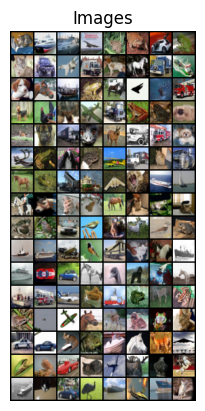

In [3]:
x, y = next(iter(val_loader))

plt.imshow(torchvision.utils.make_grid(x).permute(1, 2, 0))
plt.title("Images")
plt.axis("off")
plt.show()

In [41]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Block, self).__init__()
        self.conv1 = DepthwiseSeparableConv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = DepthwiseSeparableConv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = DepthwiseSeparableConv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.conv1(self.bn1(x)))
        x = x + self.act(self.conv2(self.bn2(x)))
        x = x + self.act(self.conv3(self.bn3(x)))

        x = F.max_pool2d(x, 2)

        return x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = Block(3, 16, 3, 1, 1)
        self.conv2 = Block(16, 32, 3, 1, 1)
        self.conv3 = Block(32, 64, 3, 1, 1)
        self.conv4 = Block(64, 64, 3, 1, 1)

        self.fc = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64 * 2 * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

        # sdict = torch.load("model.pth")

    def forward(self, x, lpips=False):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        # x5 = self.conv5(x4)

        x4 = x4.view(x4.size(0), -1)
        x = self.fc(x4)

        if lpips:
            return x, x1, x2, x3, x4

        return x
    
    def lpips(self, img1, img2, linear=False):
        # Forward pass with lpips=True to get feature maps
        features1 = self.forward(img1, lpips=True)
        features2 = self.forward(img2, lpips=True)

        # Calculate the LPIPS score
        if linear:
            scores = list(map(lambda x, y: F.mse_loss(x, y), features1, features2))
        else:
            scores = list(map(lambda x, y: F.mse_loss(x, y), features1[1:], features2[1:]))

        # Sum the distances to get the LPIPS score
        lpips_score = sum(scores)

        return lpips_score
    
model = Model()
model = model.to("mps")
print(summary(model, input_size=(1, 3, 32, 32), device="mps", depth=1))

Layer (type:depth-idx)                        Output Shape              Param #
Model                                         [1, 10]                   --
├─Block: 1-1                                  [1, 16, 16, 16]           1,028
├─Block: 1-2                                  [1, 32, 8, 8]             3,616
├─Block: 1-3                                  [1, 64, 4, 4]             12,352
├─Block: 1-4                                  [1, 64, 2, 2]             14,784
├─Sequential: 1-5                             [1, 10]                   68,362
Total params: 100,142
Trainable params: 100,142
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.94
Input size (MB): 0.01
Forward/backward pass size (MB): 1.83
Params size (MB): 0.40
Estimated Total Size (MB): 2.24


In [42]:
from ema_pytorch import EMA

ema = EMA(model, beta=0.999, update_after_step=100, update_every=10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [43]:
@torch.no_grad()
def eval(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    for x, y in loader:
        x, y = x.to("mps"), y.to("mps")
        y_hat = model(x)
        pred = y_hat.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()
        total += len(x)
        loss += F.cross_entropy(y_hat, y).item()
    return correct / total, loss / len(loader)

roll_loss = 0
for epoch in range(200):
    model.train()
    val_acc, val_loss = eval(model, val_loader)
    lpips = model.lpips(torch.ones(4, 3, 32, 32, device="mps"), torch.zeros(4, 3, 32, 32, device="mps")).item()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", ncols=150)
    for x, y in pbar:
        x, y = x.to("mps"), y.to("mps")
        optimizer.zero_grad()
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()

        ema.update()

        roll_loss = 0.99 * roll_loss + 0.01 * loss.item()
        pbar.set_postfix_str(f"loss: {roll_loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.2%}, lpips: {lpips:.4f}")
    

Epoch 19: 100%|████████████████████████████████████| 391/391 [00:14<00:00, 27.34it/s, loss: 0.9122, val_loss: 1.2099, val_acc: 58.53%, lpips: 82.7722]


KeyboardInterrupt: 

In [44]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
# plot the distribution of weights for each layer
plt.subplot()